# Objective:
- Purpose of the project is to practice EDA using pandas

# Data source: 
- https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data
- https://www.kaggle.com/code/gaborfodor/from-eda-to-the-top-lb-0-367

In [1]:
%matplotlib inline
import pandas as pd # data processing
import numpy as np # linear algebra
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

## Data understanding

In [2]:
np.random.seed(10)
N = 100000 #number of sample rows in plots
t0 = dt.datetime.now()
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print('we have {} training rows and {} test rows.'.format(train.shape[0], test.shape[0]))
print('we have {} training columns and {} test columns.'.format(train.shape[1], test.shape[1]))
train.head(2)

we have 1458644 training rows and 625134 test rows.
we have 11 training columns and 9 test columns.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [4]:
train.count().min()

1458644

In [5]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('Id is not unique.')
print('Train and Test sets are distinct.') if len(np.intersect1d(train.id.values, test.id.values)) == 0 else print('Train and Test sets are not distinct')
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] else print('There are missing values.')
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique())))) 

Id is unique.
Train and Test sets are distinct.
We do not need to worry about missing values.
The store_and_fwd_flag has only two values {'Y', 'N'}.


In [6]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x:x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference) == 0 else print('Trip_duration and datetimes are not ok.')

Trip_duration and datetimes are ok.


In [7]:
train['trip_duration'].max() // 3600

979

We can see that the max trip_duration is  ~ 1000 hours. Fortunately the evaluation metric is RMSLE and not RMSE. Outliers will cause less trouble. We could logtransform out target label and use RMSE during training.

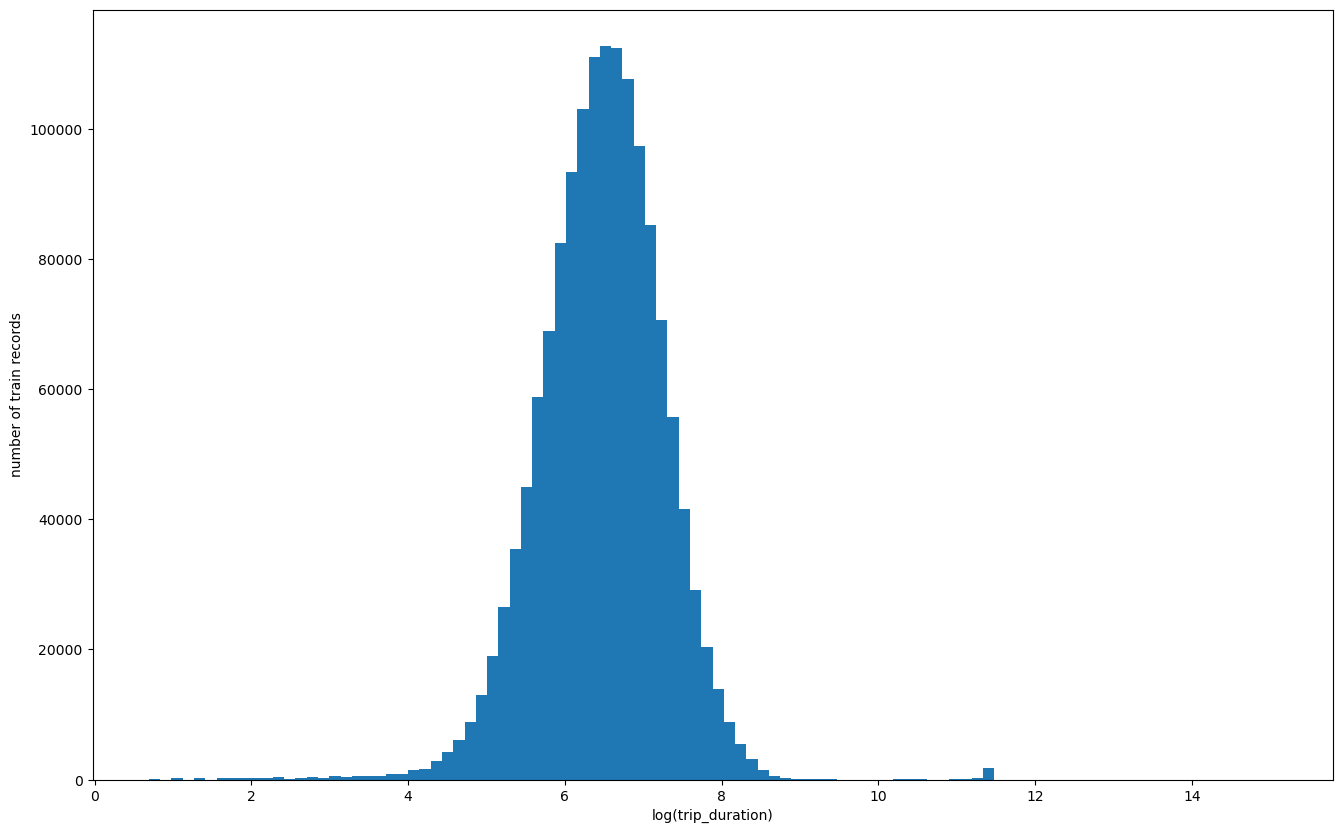

In [8]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins = 100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

## Validation Strategy

First let's check the train test split. It helps to decide our validation strategy and gives ideas about feature engineering.

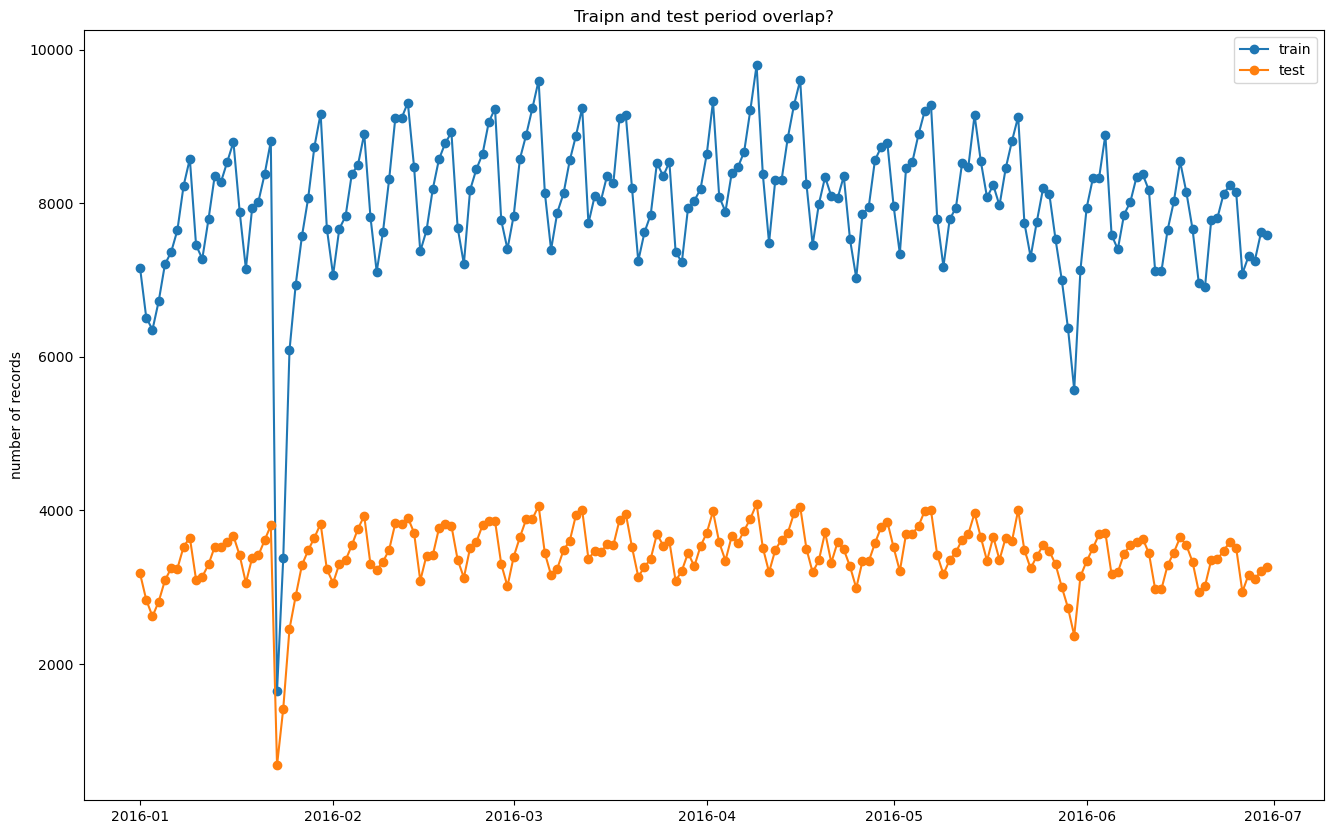

In [9]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label = 'train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label = 'test')
plt.title('Traipn and test period overlap?')
plt.legend(loc = 0)
plt.ylabel('number of records')
plt.show()

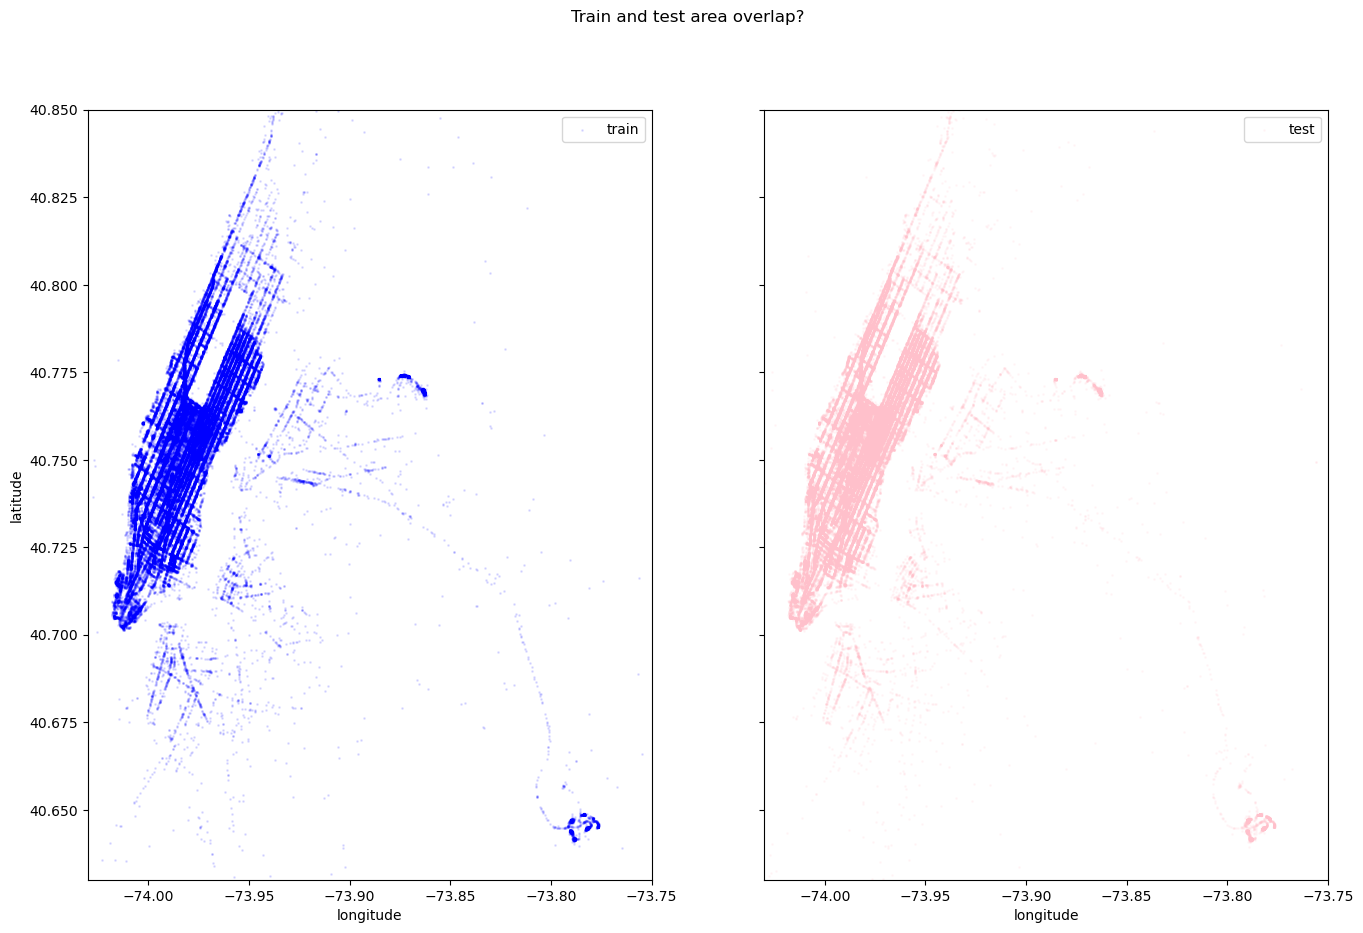

In [10]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols = 2, sharex = True, sharey = True)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N], color = 'blue', s = 1, label = 'train', alpha = 0.1)
ax[1].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N], color = 'pink', s = 1, label = 'test', alpha = 0.1)
fig.suptitle('Train and test area overlap?')
ax[0].legend(loc = 0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc = 0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In this case the train and test split seems to be random. This allows us to use unsupervised learning and feature extraction to be applied on the full data set.

# Feature Extraction

## PCA

We use PCA to transform longitude and latitude coordinates. In this case it is not about dimension reduction since we transform 2D -> 2D. The rotation could help for decision tree splits.

In [11]:
coords = np.vstack((
    train[['pickup_latitude', 'pickup_longitude']].values,
    train[['dropoff_latitude', 'dropoff_longitude']].values,
    test[['pickup_latitude', 'pickup_longitude']].values,
    test[['dropoff_latitude', 'dropoff_longitude']].values
))
pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

(-0.13426186697746503, 0.1017816834266389)

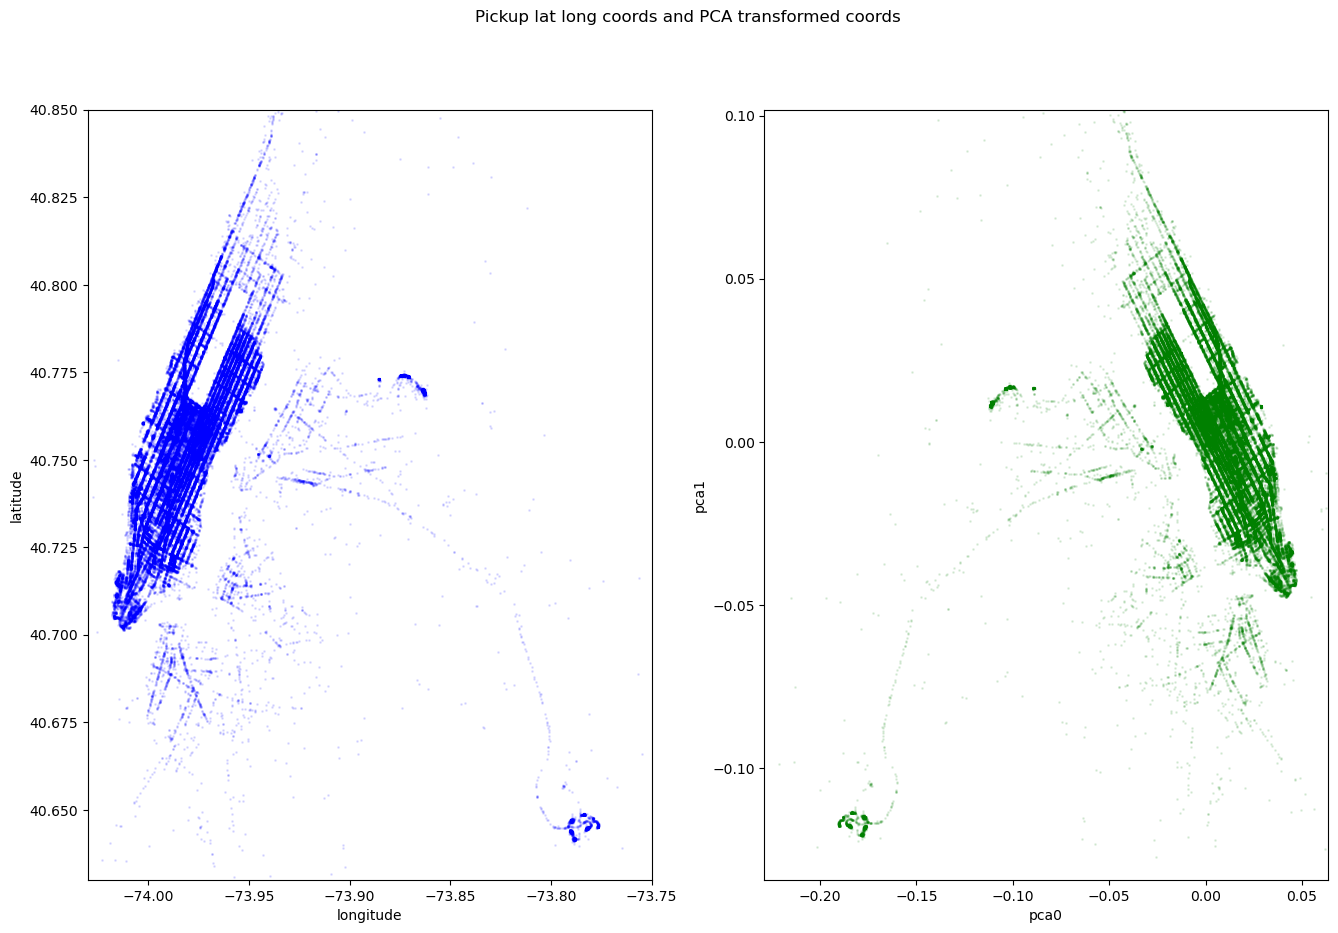

In [12]:
fig, ax = plt.subplots(ncols = 2)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N], color = 'blue', s=1, alpha = 0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N], color = 'green', s=1, alpha = 0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())

## Distance

Let's calculate the distance (km) between pickup and dropoff points. Currently Haversine is used, geopy has another heuristics (vincenty() or great_circle()) if you prefer. The cabs are not flying and we are in New York so we  could check the manhattan (L1) distance too.

pd.DataFrame.apply() would be too slow so the haversine is rewritten to handle arrays. We extract the middle of the path as a feature as well.

In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_ditance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371 # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

